  # Test of MLP model
  
 
 


In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter

from scipy.stats import randint as sp_randint
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import QuantileTransformer
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import BalancedBatchGenerator
from imblearn.keras import balanced_batch_generator
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

  ### Definition of names for plots and files

In [2]:

date = '20191119'

#names of files with detections, features and labels for the training set (v3)
labels_file = '../alerce_trainingset/training_set_v5.1/dfcrossmatches_prioritized_v5.1.csv'

features_file = '../ZTF_data/features_20200109_with_WISE.csv'

class_output = '../ZTF_classifications/MLP_classification_unlabelled_set_'+date+'.csv'

#where the RF models are saved
model_name = 'stat_MLP/MLP_'+date

#confusion matrixes
conf_matrix_name = 'stat_MLP/confusion_matrix_MLP_'+date


### reading the training set files 

In [3]:
df_feat = pd.read_csv(features_file,index_col='oid')
df_labels = pd.read_csv(labels_file,index_col='oid')


#'''
df_feat['W2-W3']=df_feat['W2']-df_feat['W3']
df_feat.loc[(df_feat['W3']==np.nan) |(df_feat['W2']==np.nan) |(df_feat['W2']==-999)|(df_feat['W3']==-999), 'W2-W3']=-999

df_feat['r-W3']=df_feat['Mean_2']-df_feat['W3']
df_feat.loc[(df_feat['Mean_2']==np.nan) |(df_feat['W3']==np.nan) | (df_feat['Mean_2']==-999)|(df_feat['W3']==-999) , 'r-W3']=-999
df_feat.loc[(df_feat['r-W3']>500) | (df_feat['r-W3']<-500) ,'r-W3']=-999 

df_feat['r-W2']=df_feat['Mean_2']-df_feat['W2']
df_feat.loc[(df_feat['Mean_2']==np.nan) |(df_feat['W2']==np.nan) | (df_feat['Mean_2']==-999)|(df_feat['W2']==-999), 'r-W2']=-999
df_feat.loc[(df_feat['r-W2']>500) | (df_feat['r-W3']<-500),'r-W2']=-999 

df_feat['g-W3']=df_feat['Mean_1']-df_feat['W3']
df_feat.loc[(df_feat['Mean_1']==np.nan) |(df_feat['W3']==np.nan) | (df_feat['Mean_1']==-999)|(df_feat['W3']==-999) , 'g-W3']=-999
df_feat.loc[(df_feat['g-W3']>500) | (df_feat['g-W3']<-500) ,'g-W3']=-999 

df_feat['g-W2']=df_feat['Mean_1']-df_feat['W2']
df_feat.loc[(df_feat['Mean_1']==np.nan) |(df_feat['W2']==np.nan) | (df_feat['Mean_1']==-999)|(df_feat['W2']==-999), 'g-W2']=-999
df_feat.loc[(df_feat['g-W2']>500) | (df_feat['g-W3']<-500),'g-W2']=-999
#'''



#discarging infinite values
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

print(df_labels['class_source'].values.size)

170976


In [4]:
#creating new labels to combine SNII and SNIIb classes, and to add RS-CVn as a new class
df_labels['class_original'] = df_labels['classALeRCE']
#df_labels.loc[(df_labels['class_source'] == 'RS CVn'), 'class_original'] = 'RS-CVn'
df_labels.loc[(df_labels['class_original'] == 'SNIIn'), 'class_original'] = 'SNII'
df_labels.loc[(df_labels['class_original'] == 'EA'), 'class_original'] = 'EB'
df_labels.loc[(df_labels['class_original'] == 'EB/EW'), 'class_original'] = 'EB'


#defining the classes included in the RF model
label_order = ['QSO','AGN', 'Blazar', 'CV/Nova', 'YSO','LPV', 'SNIa', 'SNIbc', 'SNII',
               'SLSN', 'EB', 'DSCT', 'RRL', 'Ceph','Periodic-Other']

#label_order = ['QSO-I','AGN-I', 'Blazar']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

labels.head()

,class_original
oid,
ZTF19aavdfaf,CV/Nova
ZTF19aaniokz,CV/Nova
ZTF18accatjz,CV/Nova
ZTF19aarfrrf,CV/Nova
ZTF19aarfrre,CV/Nova


In [5]:
#defining columns excluded from the df_nd table

rm_nd_cols = [
'n_det_1',
'n_det_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'first_mag_1',
'first_mag_2',
'aps_non_zero_1',
'aps_non_zero_2',
'mean_mag_1',
'mean_mag_2',
'min_mag_1',
'min_mag_2',
'W1','W2','W3','W4','u','g','r','i','z','u_g','g_r','r_i','i_z',  
'iqr_1',
'iqr_2', 
'delta_mjd_fid_1',
'delta_mjd_fid_2',      
]
'''
'max_mjd_fid_1',
'max_mjd_fid_2',
'min_mjd_fid_1',
'min_mjd_fid_2',
'max_mag_fid_1',
'max_mag_fid_2',
'min_mag_fid_1',
'min_mag_fid_2',
'first_mag_fid_1',
'first_mag_fid_2',
'first_mjd_fid_1',
'first_mjd_fid_2']
'''


df = labels.join(df_feat.drop(rm_nd_cols, axis=1),how='inner')
print(df['g-r_max'].values.size)

df = df.replace([np.inf, -np.inf], np.nan)
print(df['g-r_max'].values.size)
df_train = df.copy()
df_train = df_train.fillna(-999)
labels = df[['class_original']]
df.drop(['Mean_1','Mean_2','class_original'], axis=1, inplace=True)
df = df.fillna(-999)

print(len(labels['class_original'].values))

print(df['g-r_max'].values.size)
df.head()

115941
115941
115941
115941


,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,positive_fraction_1,positive_fraction_2,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18abcoxgp,1.777660,1.612033,1.0,1.0,6.0,8.0,0.607143,0.626866,0.018519,0.000000,...,0.125000,0.194030,0.886667,0.983125,-999.000,-999.000,-999.000000,-999.000000,-999.000000,-999.000000
ZTF18aaavxnm,1.545494,1.355183,1.0,1.0,1.0,1.0,0.100000,0.163636,0.000000,0.018868,...,0.700000,0.763636,0.808571,1.000000,0.439,1.925,4.700925,2.775925,4.654902,2.729902
ZTF18abmefme,1.741148,1.508885,1.0,1.0,1.0,1.0,0.529412,0.521739,0.000000,0.000000,...,0.431373,0.413043,0.912857,0.996042,0.168,2.829,4.799764,1.970764,4.865939,2.036939
ZTF17aabumpu,1.689769,1.102787,1.0,1.0,1.0,1.0,0.176471,0.315789,0.000000,0.000000,...,0.735294,0.631579,0.846667,0.790198,0.026,0.576,2.432245,1.856245,2.667624,2.091624
ZTF18aazmwvg,2.734478,2.477687,1.0,1.0,2.0,3.0,0.428571,0.442623,0.021277,0.000000,...,0.571429,0.655738,0.807857,0.980625,0.440,3.472,4.365933,0.893933,4.910711,1.438711


  ### Defining functions to plot the confusion matrix and the feature importance

In [6]:
def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    
    print(cm)

    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 17)
    plt.yticks(tick_marks, classes, fontsize = 17)

    #fmt = '.2f' if normalize else 'd'
    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%d"%  (cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize = 16)

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 18)
    plt.xlabel('Predicted label',fontsize = 18)
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()
    
    
def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(model.feature_importances_))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name)
    #plt.close()

### Pre-processing training data

In [7]:
Y_original = labels['class_original'].values

le = LabelEncoder()

Y_original_encoded = le.fit_transform(Y_original)

X_original = df.values


#splitting training set
X_train_original, X_test_original, y_train_original, y_test_original = model_selection.train_test_split(X_original,
                                                Y_original_encoded, test_size=0.2, stratify=Y_original_encoded)

'''scaler = MinMaxScaler()
scaler.fit(X_train_original)'''

scaler = QuantileTransformer(n_quantiles=1000, random_state=0)
scaler.fit(X_train_original)

X_train = scaler.transform(X_train_original)
X_test = scaler.transform(X_test_original)

X_train, X_valid, y_train_original, y_valid_original = model_selection.train_test_split(X_train,
                                                y_train_original, test_size=0.2, stratify= y_train_original)

y_train = keras.utils.to_categorical(y_train_original, len(label_order))
y_valid = keras.utils.to_categorical(y_valid_original, len(label_order))
y_test = keras.utils.to_categorical(y_test_original, len(label_order))

print(len(y_train_original))
print(X_train.shape[1])
print(y_train)

74201
136
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


  ## Balanced MLP
  

In [8]:
#defining the MLP:

model = Sequential()

model.add(Dense(units=X_train.shape[1],activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=128,activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(units=64,activation='relu'))

#output layer
model.add(Dense(units=len(label_order),activation='softmax'))

#compiling with Adam and categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy']) 
#model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy']) 
#model.compile(loss='categorical_crossentropy', optimizer='Adagrad', metrics=['accuracy']) 


'''model.fit(x=X_train, 
          y=y_train_original, epochs=600, verbose=1,
                                       callbacks=[early_stop],validation_data=(X_test, y_test_original))
'''

#generating balanced minibatches with imblearn
'''training_generator = BalancedBatchGenerator(X_train, y_train, 
                                            sampler=RandomOverSampler(), batch_size=len(label_order)*8)'''

training_generator, steps_per_epoch = balanced_batch_generator(X_train, y_train, 
                                      sampler=RandomOverSampler(), batch_size=len(label_order)*4)

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

callback_history = model.fit_generator(generator=training_generator, steps_per_epoch=500,epochs=600, verbose=1,
                                       callbacks=[early_stop],validation_data=(X_valid, y_valid))

Epoch 1/600
500/500 [==============================] - 7s 14ms/step - loss: 1.6755 - accuracy: 0.2673 - val_loss: 1.0654 - val_accuracy: 0.6596
Epoch 2/600
500/500 [==============================] - 7s 13ms/step - loss: 1.1859 - accuracy: 0.5291 - val_loss: 0.9031 - val_accuracy: 0.6574
Epoch 3/600
500/500 [==============================] - 7s 13ms/step - loss: 1.0581 - accuracy: 0.5960 - val_loss: 0.8096 - val_accuracy: 0.7316
Epoch 4/600
500/500 [==============================] - 7s 13ms/step - loss: 0.9912 - accuracy: 0.6275 - val_loss: 0.8123 - val_accuracy: 0.6955
Epoch 5/600
500/500 [==============================] - 7s 13ms/step - loss: 0.9287 - accuracy: 0.6531 - val_loss: 0.7748 - val_accuracy: 0.7194
Epoch 6/600
500/500 [==============================] - 7s 14ms/step - loss: 0.8799 - accuracy: 0.6740 - val_loss: 0.8235 - val_accuracy: 0.7000
Epoch 7/600
500/500 [==============================] - 7s 14ms/step - loss: 0.8523 - accuracy: 0.6919 - val_loss: 0.6726 - val_accuracy:

500/500 [==============================] - 7s 13ms/step - loss: 0.5356 - accuracy: 0.8063 - val_loss: 0.5022 - val_accuracy: 0.8242
Epoch 58/600
500/500 [==============================] - 7s 13ms/step - loss: 0.5335 - accuracy: 0.8062 - val_loss: 0.5142 - val_accuracy: 0.8253
Epoch 59/600
500/500 [==============================] - 7s 13ms/step - loss: 0.5248 - accuracy: 0.8117 - val_loss: 0.4822 - val_accuracy: 0.8367
Epoch 00059: early stopping


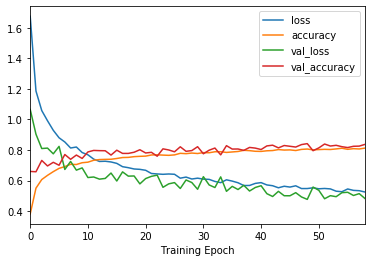

In [9]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()
plt.xlabel('Training Epoch')
plt.savefig('/Users/psanchez/Documents/Postdoc/paper_late_classifier/loss_accuracy_curves.pdf')

In [10]:
predictions = model.predict_classes(X_test)
pred_proba = model.predict(X_test)
final_proba = np.amax(pred_proba,axis=1)
print(final_proba)

[0.9817618  0.95495844 0.935333   ... 0.6367512  0.9406355  0.99972254]


[[0.19234709 0.23867624 0.46090386 ... 0.70131493 0.64978831 0.65510861]
 [0.39057973 0.         0.64335627 ... 0.         0.78706363 0.76701303]
 [0.2624062  0.20247915 0.65318762 ... 0.51831312 0.24314297 0.48800252]
 ...
 [0.65600876 0.60466454 0.27798324 ... 0.27417451 0.52309345 0.21546357]
 [0.33920445 0.4514598  1.         ... 0.76708014 0.68511603 0.76949378]
 [0.84191341 0.89817698 1.         ... 0.66272918 0.48388868 0.62720933]]


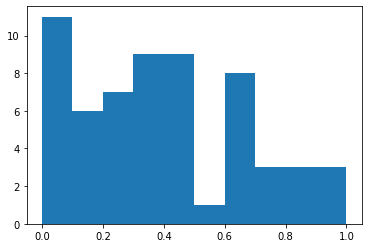

In [11]:
for x,y in training_generator:
    print(x)
    plt.hist(x[:,2])
    '''letter_counts = Counter(y)
    print(letter_counts)
    df_hist = pd.DataFrame.from_dict(letter_counts, orient='index')
    df_hist.plot(kind='bar')'''
    break
    

In [12]:


print("Accuracy:", metrics.accuracy_score(y_test_original, predictions))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test_original, predictions))
print("weighted precision: ", metrics.precision_score(y_test_original, predictions, average='weighted'))
print("weighted recall: ", metrics.recall_score(y_test_original, predictions, average='weighted'))


print("weighted F1: ", metrics.f1_score(y_test_original, predictions, average='weighted'))


#Dumping trained model

features_list = list(X_train_original)


Accuracy: 0.8394928629953857
Balanced accuracy: 0.6636443152778557
weighted precision:  0.9246275782394655
weighted recall:  0.8394928629953857
weighted F1:  0.872721651972908


In [13]:
print(y_test)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


[[1782  313  108   16   14    0    1    0    4    1    0    1    2    0
     1]
 [  31  401   22    1    9    4    3    0    3    0    0    0    0    0
     0]
 [  34   22  130    3    7    0    0    0    0    0    0    0    1    0
     0]
 [   2    0    1  126    4    1    4    0    0    0    4    4   12    0
     1]
 [   0    4   13    3  257    9    0    0    0    0    5    0    2    3
     7]
 [   1    3    1   12   70 6489    4    0    4    0    2    1    3   31
    11]
 [   0    1    0    0    0    0  138    3   16    2    0    0    0    0
     0]
 [   0    1    0    0    0    0    8    0    1    0    0    0    0    0
     0]
 [   0    1    0    0    1    0   13    0   27    2    0    0    0    0
     0]
 [   0    0    0    0    0    0    0    0    3    1    0    0    0    0
     0]
 [   6    2   13  106   67   12    0    0    0    0 5199  382  178  117
   609]
 [   0    0    0    4    0    2    0    0    0    0   16  105    4    0
     2]
 [   7    5    5  328   13    5    5    

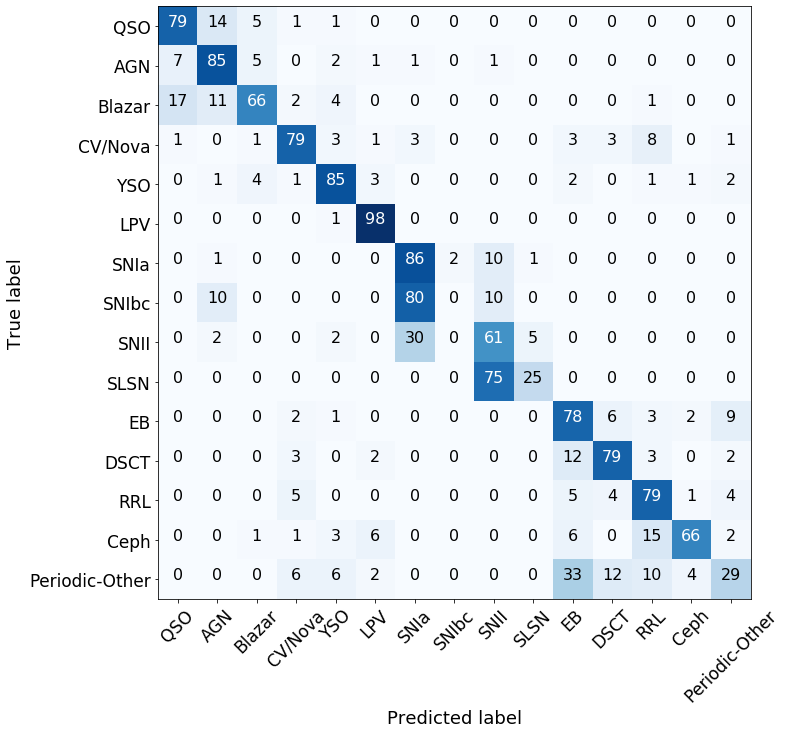

In [14]:
#plotting confusion matrix
cnf_matrix = metrics.confusion_matrix(le.inverse_transform(y_test_original), le.inverse_transform(predictions), labels=label_order)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,label_order,'../../paper_late_classifier/paper_plots/conf_matrix_MLP.pdf')

In [15]:
# Kaggle score

CLASSES_REDUCED_V2 = label_order


class_weights = list(class_weight.compute_class_weight('balanced', le.transform(label_order), y_test_original))


def kaggle_loss(labels, predictions, weights=None):
    np.clip(predictions, 10**-15, 1-10**-15, out=predictions)
    classes = le.transform(CLASSES_REDUCED_V2)#np.unique(labels)
    if weights is None:
        weights = np.ones(len(classes), dtype=np.float64)/len(classes)
    loss_sum = 0
    labels = np.array(labels)
    for i in classes:
        p = predictions[labels == i, i]
        class_score = np.mean(np.log(p))*weights[i]
        print(CLASSES_REDUCED_V2[i], class_score)
        loss_sum += class_score
    return -loss_sum/sum(weights)



print(kaggle_loss(y_test_original,pred_proba,class_weights))

SNII -22.820901264566363
QSO -0.3836130463345335
AGN -2.400053219377743
Blazar -4.733435712732034
Periodic-Other -13.993376220648106
SNIa -0.8294923054488996
RRL -0.10057355058690744
Ceph -115.44022781068246
DSCT -12.929787056189133
EB -0.9153889619959065
LPV -0.14013152191760697
YSO -3.5027108950058885
SLSN -241.43026789824168
CV/Nova -9.631781948137583
SNIbc -444.01858779430387
1.3067951839083347


  ## Classifying unlabeled data

In [16]:
#loading the data


print(rm_nd_cols)

#rm_nd_cols = ['n_det_fid_1', 'n_det_fid_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2',
#             'Mean_1','Mean_2','paps_non_zero_1','paps_non_zero_2']

'''rm_nd_cols = [
'n_det_fid_1',
'n_det_fid_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'Mean_1',
'Mean_2',
'paps_non_zero_1',
#'paps_PN_flag_1',
'paps_non_zero_2',
#'paps_PN_flag_2',
]'''

mean_drop = ['Mean_1','Mean_2']

df_feat_ul = df_feat.drop(rm_nd_cols, axis=1)
df_feat_ul = df_feat_ul.drop(mean_drop, axis=1)
#df_feat_ul = df_feat_ul.join(df_wise.drop(wise_drop, axis=1))
df_feat_ul = df_feat_ul.replace([np.inf, -np.inf], np.nan)
df_feat_ul.fillna(-999,inplace=True)


    
df_feat_ul_out = df_feat_ul
    
#df_feat_ul_stochastic = df_feat_ul

#df_feat_ul = df_feat_ul.drop(['Mean_2'], axis=1)

df_feat_ul.head()



['n_det_1', 'n_det_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2', 'first_mag_1', 'first_mag_2', 'aps_non_zero_1', 'aps_non_zero_2', 'mean_mag_1', 'mean_mag_2', 'min_mag_1', 'min_mag_2', 'W1', 'W2', 'W3', 'W4', 'u', 'g', 'r', 'i', 'z', 'u_g', 'g_r', 'r_i', 'i_z', 'iqr_1', 'iqr_2', 'delta_mjd_fid_1', 'delta_mjd_fid_2']


,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,positive_fraction_1,positive_fraction_2,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaaaxg,0.200738,0.215184,1.0,1.000000,1.0,1.0,0.452381,0.450000,0.0,0.0,...,0.380952,0.350000,0.739524,0.894375,-0.056,1.655,3.797847,2.142847,4.394539,2.739539
ZTF17aaaadvq,-999.000000,0.316305,-999.0,1.000000,-999.0,1.0,-999.000000,0.055556,-999.0,0.0,...,-999.000000,0.944444,0.690000,0.982625,0.046,1.619,4.563254,2.944254,-999.000000,-999.000000
ZTF17aaaadyl,-999.000000,0.326172,-999.0,1.000000,-999.0,1.0,-999.000000,0.151515,-999.0,0.0,...,-999.000000,0.848485,0.690000,0.988732,-999.000,-999.000,-999.000000,-999.000000,-999.000000,-999.000000
ZTF17aaaafce,0.207151,0.198148,1.0,0.999998,1.0,1.0,0.513514,0.428571,0.0,0.0,...,0.243243,0.571429,0.696667,0.993333,-0.029,1.705,3.663143,1.958143,4.416657,2.711657
ZTF17aaaajfv,0.656590,0.488236,1.0,1.000000,1.0,1.0,0.634615,0.508621,0.0,0.0,...,0.442308,0.362069,0.768333,0.985083,-0.351,2.636,4.331154,1.695154,5.044343,2.408343


In [17]:
#predicting classes of unlabeled data

x_test_scaled = scaler.transform(df_feat_ul)
print(x_test_scaled.shape)
test_Y = le.inverse_transform(model.predict_classes(x_test_scaled))
test_Y_proba = model.predict(x_test_scaled)

(690527, 136)


In [18]:
print(np.amax(test_Y_proba,axis=1))

[0.9401923  0.8656719  0.68622047 ... 0.74226356 0.76885945 0.69144297]


In [19]:
#Writing results in the output

df_out = df_feat_ul_out
print(df_out.shape)

df_out['predicted_class'] = test_Y
df_out['predicted_class_proba'] = np.amax(test_Y_proba,axis=1)
test_data_withclass = df_out

'''
probs_header = prob_final_class_names_ul + '_prob'

prob_pd_ul = pd.DataFrame(prob_final_ul,columns=probs_header,index=df_out.index)

prob_h_pd_ul = pd.DataFrame(test_Y_proba_hierarchical, columns=['prob_Periodic','prob_Stochastic','prob_Transient'],index=df_out.index)

test_data_withclass = df_out.join(prob_pd_ul).join(prob_h_pd_ul)

test_data_withclass.to_csv(class_output)

test_data_withclass.head()
'''

(690527, 136)


"\nprobs_header = prob_final_class_names_ul + '_prob'\n\nprob_pd_ul = pd.DataFrame(prob_final_ul,columns=probs_header,index=df_out.index)\n\nprob_h_pd_ul = pd.DataFrame(test_Y_proba_hierarchical, columns=['prob_Periodic','prob_Stochastic','prob_Transient'],index=df_out.index)\n\ntest_data_withclass = df_out.join(prob_pd_ul).join(prob_h_pd_ul)\n\ntest_data_withclass.to_csv(class_output)\n\ntest_data_withclass.head()\n"

In [20]:
test_data_withclass.shape
#class_final_name_ul = le_original.inverse_transform(class_final_name_ul)

(690527, 138)

Text(0.5, 1.0, 'sources classified')

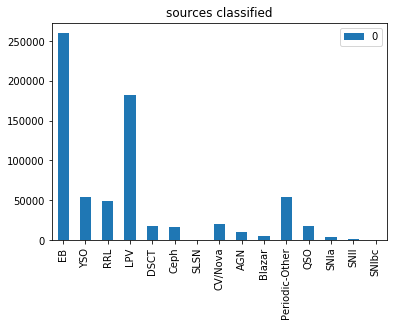

In [21]:
letter_counts = Counter(test_Y)
df_hist = pd.DataFrame.from_dict(letter_counts, orient='index')
df_hist.plot(kind='bar')
#plt.yscale('log')
plt.title('sources classified')


0 QSO 0.6898149847984314
1 AGN 0.6970973610877991
2 Blazar 0.5324985682964325
3 CV/Nova 0.5666012167930603
4 YSO 0.6319491863250732
5 LPV 0.9763245582580566
6 SNIa 0.8804759979248047
7 SNIbc 0.856576681137085
8 SNII 0.7185916006565094
9 SLSN 0.7592151761054993
10 EB 0.7263962626457214
11 DSCT 0.6094299256801605
12 RRL 0.7541370987892151
13 Ceph 0.5616632401943207
14 Periodic-Other 0.5983221530914307


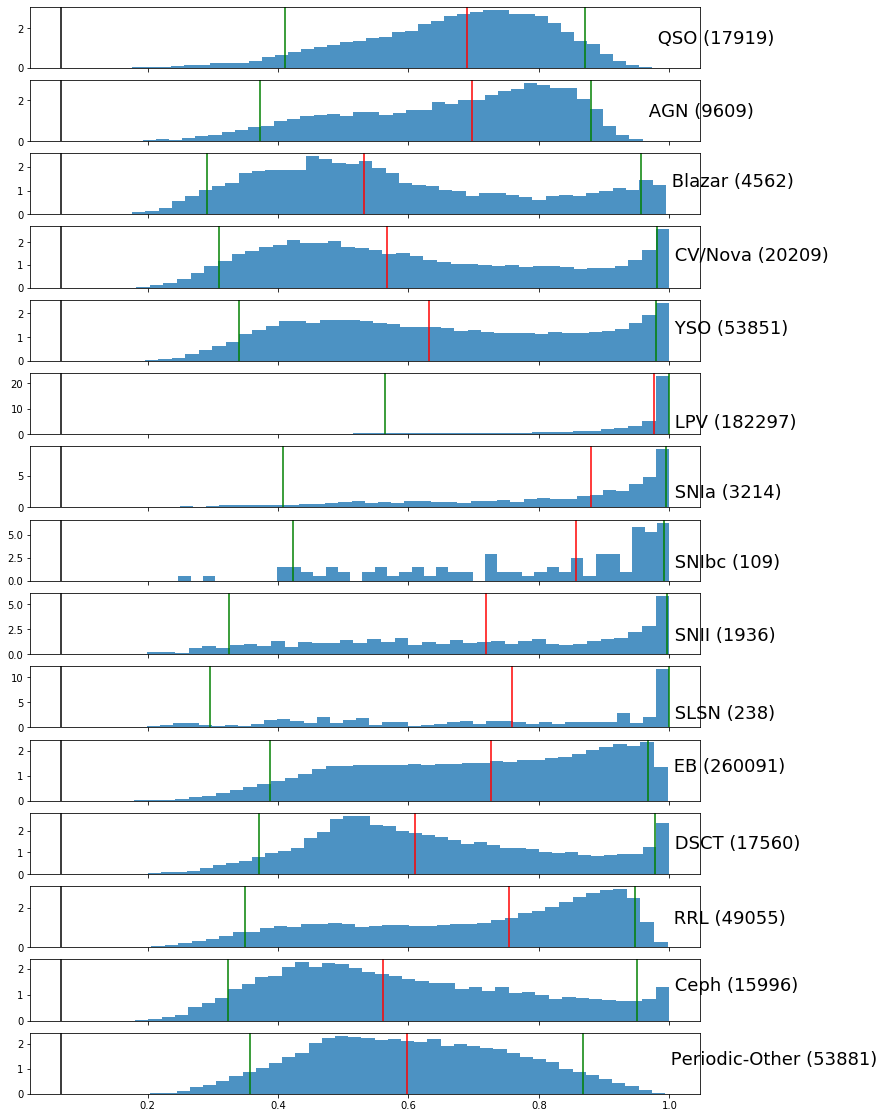

In [22]:

fig, ax = plt.subplots(nrows = len(label_order), figsize=(12, 20), sharex=True)
for idx, cl in enumerate(label_order):
   #print(idx, cl)
   print(idx, cl, np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.))
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 95.), c='g')
   ax[idx].axvline(1/len(label_order), c = 'k')
   ax[idx].hist(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, density=True, bins=40, lw=5, label=cl, alpha=0.8)
   ax[idx].text(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].max(), 1., " %s (%i)" % (cl, test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].shape[0]), fontsize=18, va='bottom', ha='left')

0 QSO 0.12020962135999902
1 AGN 0.15275001525879972
2 Blazar 0.3959230603899968
3 CV/Nova -0.030018332326600117
4 YSO 1.4772534521442013
5 LPV 2.266505623197901
6 SNIa 0.012802124023501449
7 SNIbc 0.4464168548583949
8 SNII 0.17797470092779832
9 SLSN 0.12889289855959873
10 EB 0.5514179556174971
11 DSCT 0.03834754843620125
12 RRL 0.057263586893602884
13 Ceph 0.8165257043900986
14 Periodic-Other 0.4976799340604998


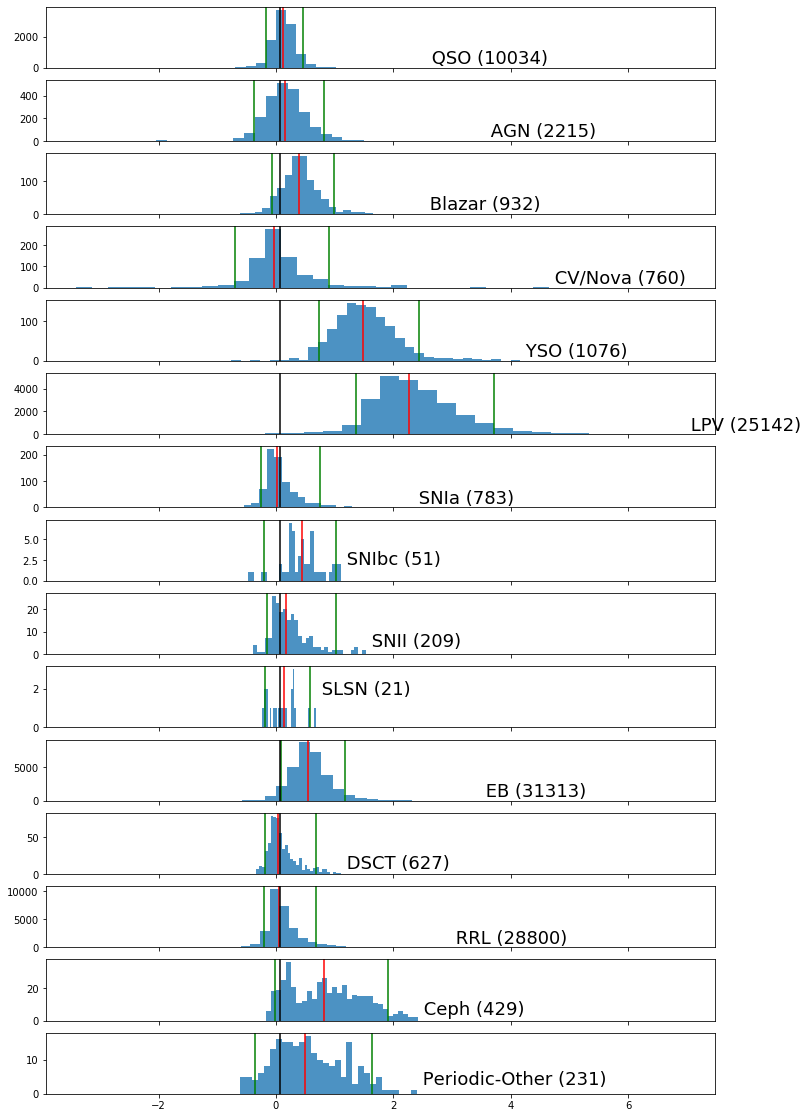

In [23]:
feature = 'g-r_max'
logscale = False
df_train_plot = df_train#.join(labels)
df_train_plot = df_train_plot.loc[df_train_plot[feature]>-999] 
fig, ax = plt.subplots(nrows = len(label_order), figsize=(12, 20), sharex=True)

for idx, cl in enumerate(label_order):
   #print(idx, cl)
   print(idx, cl, np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 50.))
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 95.), c='g')
   ax[idx].axvline(1/len(label_order), c = 'k')
   if logscale: 
      feat = np.log10(df_train_plot[feature][df_train_plot['class_original']==cl].values)
      feat = feat[feat>0]
      ax[idx].hist(np.log10(df_train_plot[feature][df_train_plot['class_original']==cl].values), density=False, bins=30, lw=5, label=cl, alpha=0.8)
   else: ax[idx].hist(df_train_plot[feature][df_train_plot['class_original']==cl].values, density=False, bins=30, lw=5, label=cl, alpha=0.8)
   ax[idx].text(df_train_plot[feature][df_train_plot['class_original']==cl].max(), 1.5, " %s (%i)" % (cl, df_train_plot[feature][df_train_plot['class_original']==cl].shape[0]), fontsize=18, va='bottom', ha='left')

#plt.savefig('../feature_analysis_train_set/'+feature+'.pdf')

QSO 15386
AGN 8417
SNIa 2874


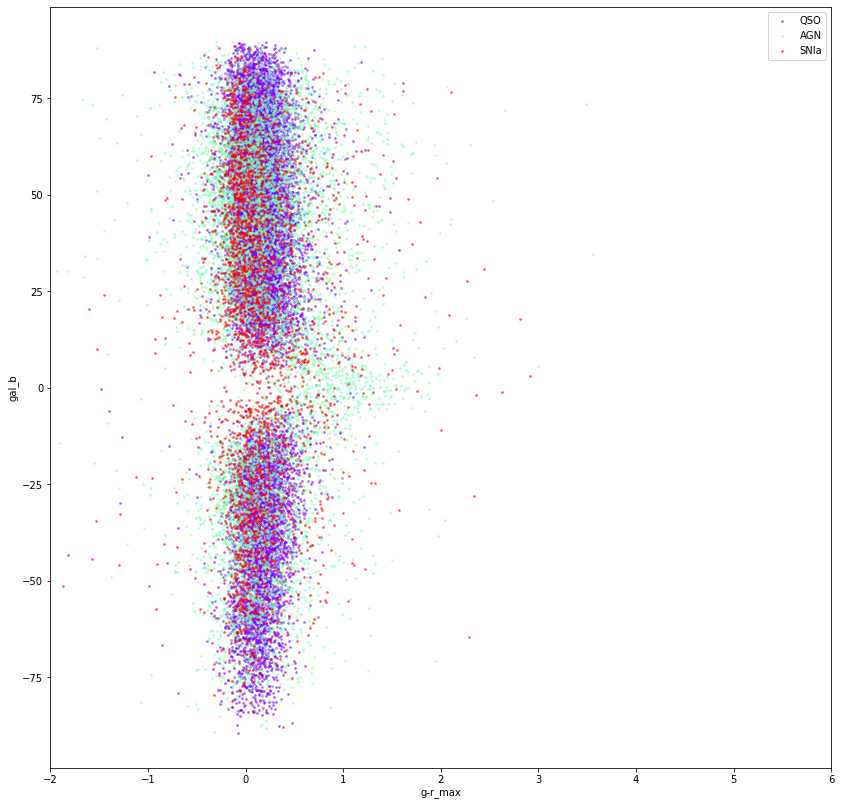

In [24]:
import matplotlib.cm as cm

feature_x = 'g-r_max'
feature_y = 'gal_b'
#labels_list = ['RS-CVn','Ceph','LPV','RRL','AGN-I','Blazar','SNIa']
labels_list = ['QSO','AGN','SNIa']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))
#df_train = df_train.join(labels)
df_test = test_data_withclass.loc[(test_data_withclass[feature_y]>-999) & (test_data_withclass[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(14, 14))
ax.set_xlim(-2,6)

for idx, cl in enumerate(labels_list):
   #print(idx, cl)
   print(cl,len(df_test[feature_x][df_test['predicted_class']==cl].values))
   ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,color=colors[idx],alpha = 0.5, s = 3,label=cl)
   
plt.legend()
plt.xlabel('g-r_max')
plt.ylabel('gal_b')
plt.savefig('../feature_analysis_train_set/color_gal_b_selection.png')

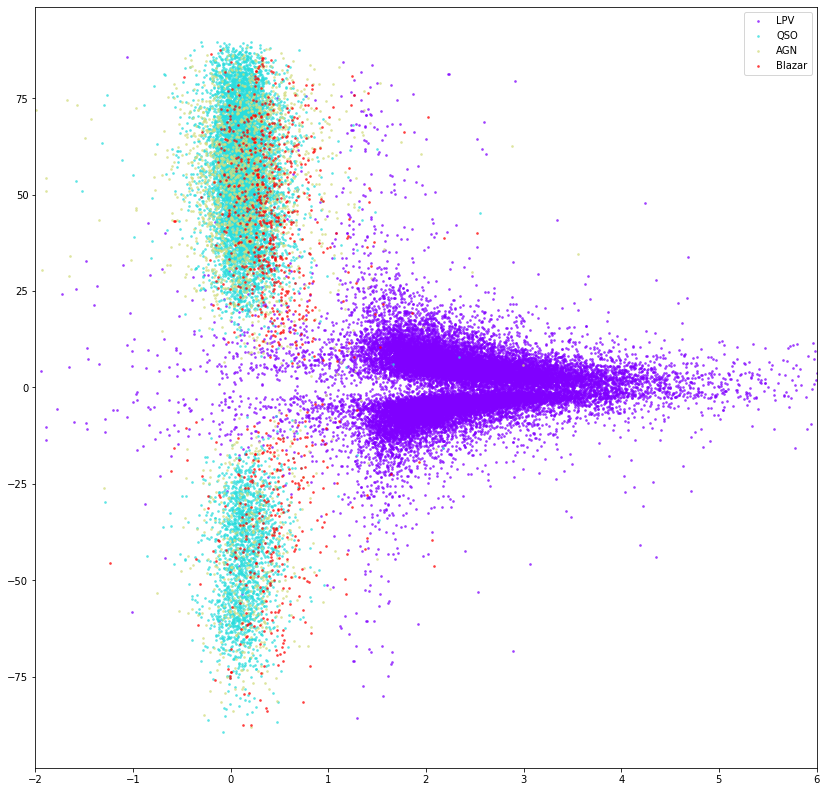

In [25]:
import matplotlib.cm as cm

feature_x = 'g-r_max'#'GP_DRW_sigma_1'
feature_y = 'gal_b' #'GP_DRW_tau_1'
labels_list = ['LPV','QSO','AGN','Blazar']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))

df_plot = df.join(labels)
df_plot= df_plot.loc[(df_plot[feature_y]>-999) & (df_plot[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(14, 14))
ax.set_xlim(-2,6)
#ax.set_xlim(-4,3)
#ax.set_ylim(-4,5)
for idx, cl in enumerate(labels_list):
   #print(idx, cl)
   ax.scatter(df_plot[feature_x][df_plot['class_original']==cl].values,df_plot[feature_y][df_plot['class_original']==cl].values,color=colors[idx],alpha=0.6,s = 3,label=cl)
   #ax.scatter(np.log10(df_plot[feature_x][df_plot['class_original']==cl].values),np.log10(df_plot[feature_y][df_plot['class_original']==cl].values),color=colors[idx],alpha=0.6,label=cl)
   
plt.legend()
#plt.savefig('../feature_analysis_train_set/'+feature+'.pdf')